<a href="https://colab.research.google.com/github/mendesrafael965/Testes_Series_Temporais/blob/main/Previsoes_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [ ]:
base = pd.read_csv('petr4_treinamento.csv')
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [ ]:
#Retira os valores NaN
base = base.dropna()

#Selecionar coluna especifica "valor de abertura"
base_treinamento = base.iloc[:,1:2].values

#Normaliza os dados
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)


In [ ]:
#Preparação dos dados para usar em séries temporais
#1 - Definir o intervalo de tempo
#2 - 
#3 - 

#Vamos utilizar os 90 dias anteriores
previsores = []
preco_real = []

#Devo começar na posição igual ao número de dias de atraso-1
for i in range(90,1242):

  #Previsores recebe valore de 0 até 90 (1º ite)
  previsores.append(base_treinamento_normalizada[i-90:i,0])
  preco_real.append(base_treinamento_normalizada[i,0])

#Transforma para numpy
previsores, preco_real = np.array(previsores), np.array(preco_real)

pd.DataFrame(data = previsores).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,0.765019,0.756298,0.781492,0.788760,0.770833,0.748062,0.754360,0.758236,0.765988,0.765988,0.760174,0.758721,0.755814,0.744671,0.737403,0.737403,0.734981,0.752422,0.734012,0.716570,0.681202,0.675388,0.676357,0.633721,0.665213,0.656492,0.646802,0.666182,0.658430,0.649709,0.651163,0.664244,0.673450,0.642926,0.644864,0.622577,0.609496,0.609981,0.608527,0.595930,...,0.712209,0.712209,0.719477,0.703488,0.695252,0.703973,0.703973,0.697674,0.681686,0.681686,0.653101,0.666182,0.648256,0.661822,0.643411,0.678779,0.691376,0.665698,0.654070,0.642926,0.641473,0.635659,0.675872,0.686531,0.703004,0.719961,0.739826,0.765504,0.748547,0.758236,0.789244,0.765988,0.784884,0.801841,0.777616,0.773256,0.756298,0.742733,0.741279,0.742248
1,0.756298,0.781492,0.788760,0.770833,0.748062,0.754360,0.758236,0.765988,0.765988,0.760174,0.758721,0.755814,0.744671,0.737403,0.737403,0.734981,0.752422,0.734012,0.716570,0.681202,0.675388,0.676357,0.633721,0.665213,0.656492,0.646802,0.666182,0.658430,0.649709,0.651163,0.664244,0.673450,0.642926,0.644864,0.622577,0.609496,0.609981,0.608527,0.595930,0.611434,...,0.712209,0.719477,0.703488,0.695252,0.703973,0.703973,0.697674,0.681686,0.681686,0.653101,0.666182,0.648256,0.661822,0.643411,0.678779,0.691376,0.665698,0.654070,0.642926,0.641473,0.635659,0.675872,0.686531,0.703004,0.719961,0.739826,0.765504,0.748547,0.758236,0.789244,0.765988,0.784884,0.801841,0.777616,0.773256,0.756298,0.742733,0.741279,0.742248,0.761143
2,0.781492,0.788760,0.770833,0.748062,0.754360,0.758236,0.765988,0.765988,0.760174,0.758721,0.755814,0.744671,0.737403,0.737403,0.734981,0.752422,0.734012,0.716570,0.681202,0.675388,0.676357,0.633721,0.665213,0.656492,0.646802,0.666182,0.658430,0.649709,0.651163,0.664244,0.673450,0.642926,0.644864,0.622577,0.609496,0.609981,0.608527,0.595930,0.611434,0.602229,...,0.719477,0.703488,0.695252,0.703973,0.703973,0.697674,0.681686,0.681686,0.653101,0.666182,0.648256,0.661822,0.643411,0.678779,0.691376,0.665698,0.654070,0.642926,0.641473,0.635659,0.675872,0.686531,0.703004,0.719961,0.739826,0.765504,0.748547,0.758236,0.789244,0.765988,0.784884,0.801841,0.777616,0.773256,0.756298,0.742733,0.741279,0.742248,0.761143,0.761143
3,0.788760,0.770833,0.748062,0.754360,0.758236,0.765988,0.765988,0.760174,0.758721,0.755814,0.744671,0.737403,0.737403,0.734981,0.752422,0.734012,0.716570,0.681202,0.675388,0.676357,0.633721,0.665213,0.656492,0.646802,0.666182,0.658430,0.649709,0.651163,0.664244,0.673450,0.642926,0.644864,0.622577,0.609496,0.609981,0.608527,0.595930,0.611434,0.602229,0.649225,...,0.703488,0.695252,0.703973,0.703973,0.697674,0.681686,0.681686,0.653101,0.666182,0.648256,0.661822,0.643411,0.678779,0.691376,0.665698,0.654070,0.642926,0.641473,0.635659,0.675872,0.686531,0.703004,0.719961,0.739826,0.765504,0.748547,0.758236,0.789244,0.765988,0.784884,0.801841,0.777616,0.773256,0.756298,0.742733,0.741279,0.742248,0.761143,0.761143,0.774709
4,0.770833,0.748062,0.754360,0.758236,0.765988,0.765988,0.760174,0.758721,0.755814,0.744671,0.737403,0.737403,0.734981,0.752422,0.734012,0.716570,0.681202,0.675388,0.676357,0.633721,0.665213,0.656492,0.646802,0.666182,0.658430,0.649709,0.651163,0.664244,0.673450,0.642926,0.644864,0.622577,0.609496,0.609981,0.608527,0.595930,0.611434,0.602229,0.649225,0.683624,...,0.695252,0.703973,0.703973,0.697674,0.681686,0.681686,0.653101,0.666182,0.648256,0.661822,0.643411,0.678779,0.691376,0.665698,0.654070,0.642926,0.641473,0.635659,0.675872,0.686531,0.703004,0.719961,0.739826,0.765504,0.748547,0.758236,0.789244,0.765988,0.784884,0.801841,0.777616,0.773256,0.756298,0.742733,0.741279,0.742248,0.761143,0.761143,0.774709,0.778585


In [ ]:
#Colocar a base de dados no formato que o queras pode trabalhar
#Último parâmetro utilizado indica a quantidade de indicadores ou provisores 
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1],1))

In [ ]:
regressor = Sequential()

#units = Número de células de memória
#return_sequences = Indica se os dados serão passados para a
#próxima camada
regressor.add(LSTM(units = 100, return_sequences=True, input_shape = (previsores.shape[1],1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1, activation = 'linear'))

regressor.compile(optimizer='rmsprop', loss='mean_squared_error',
                  metrics = ['mean_absolute_error'])
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)


Epoch 1/100
36/36 [==============================] - 12s 164ms/step - loss: 0.0759 - mean_absolute_error: 0.1985
Epoch 2/100
36/36 [==============================] - 6s 163ms/step - loss: 0.0161 - mean_absolute_error: 0.1012
Epoch 3/100
36/36 [==============================] - 6s 165ms/step - loss: 0.0146 - mean_absolute_error: 0.0942
Epoch 4/100
36/36 [==============================] - 6s 170ms/step - loss: 0.0122 - mean_absolute_error: 0.0851
Epoch 5/100
36/36 [==============================] - 6s 171ms/step - loss: 0.0098 - mean_absolute_error: 0.0762
Epoch 6/100
36/36 [==============================] - 6s 175ms/step - loss: 0.0110 - mean_absolute_error: 0.0800
Epoch 7/100
36/36 [==============================] - 6s 174ms/step - loss: 0.0106 - mean_absolute_error: 0.0770
Epoch 8/100
36/36 [==============================] - 6s 173ms/step - loss: 0.0081 - mean_absolute_error: 0.0690
Epoch 9/100
36/36 [==============================] - 6s 172ms/step - loss: 0.0087 - mean_absolute_error

In [ ]:
base_teste = pd.read_csv('petr4_teste.csv')
preco_real_teste = base_teste.iloc[:,1:2].values

base_completa = pd.concat((base['Open'], base_teste['Open']), axis=0)
entradas = base_completa[len(base_completa)-len(base_teste)-90:].values
entradas = entradas.reshape(-1,1)
entradas = normalizador.transform(entradas)

X_test = []
for i in range(90, 112):
  X_test.append(entradas[i-90:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

previsoes = regressor.predict(X_test)

#Desnormalizar valores
previsoes  = normalizador.inverse_transform(previsoes)



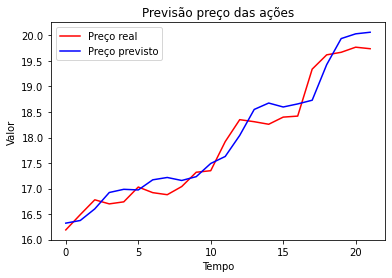

In [ ]:
plt.plot(preco_real_teste, color='red', label='Preço real')
plt.plot(previsoes, color='blue', label='Preço previsto')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [ ]:
base_teste.shape

(22, 7)